### Exact solution of the Hubbard dimer diagonalizing the full fock space.

We will write a code to plot the spectral function of the Hubbard dimer, this time diagonalizing the Full fock space rather than diagonalizing the N=1 sector and the N=2 sector separatelly in order to obtain the N, N+1 (N-1=0) energies and use them in the Lehamn representation of the Green's function as we did in the notes. 
Recall that when we did that we obtained for the N=2 solutions:

### Table 2: Two‑electron sector eigenvalues and eigenstates  

(with  $X = (U/2 + \sqrt((U/2)^2 + t^2)) / t )$) 

$$
\begin{array}{c|c|l}
\text{Eigenvalue} & \text{Eigenstate} & \text{Description} \\[6pt]
\hline\\[-6pt]
2\epsilon + \tfrac{U}{2} - \tfrac12\sqrt{U^2 + 16\,t^2}
&
\displaystyle
\frac{\;\lvert\uparrow\downarrow,0\rangle + \lvert0,\uparrow\downarrow\rangle
     + X\,\dfrac{\lvert\uparrow,\downarrow\rangle - \lvert\downarrow,\uparrow\rangle}{\sqrt{2}}\;}
     {\sqrt{\,2 + X^2\,}}
&
\text{Ground state (singlet)}
\\[12pt]
2\epsilon + U
&
\displaystyle
\frac{\lvert\uparrow\downarrow,0\rangle - \lvert0,\uparrow\downarrow\rangle}{\sqrt{2}}
&
\text{Singlet excited state}
\\[12pt]
2\epsilon + \tfrac{U}{2} + \tfrac12\sqrt{U^2 + 16\,t^2}
&
\displaystyle
\frac{\;\lvert\uparrow\downarrow,0\rangle + \lvert0,\uparrow\downarrow\rangle
     - \tfrac{1}{X}\,\dfrac{\lvert\uparrow,\downarrow\rangle - \lvert\downarrow,\uparrow\rangle}{\sqrt{2}}\;}
     {\sqrt{\,2 + 1/X^2\,}}
&
\text{Singlet excited state}
\\[12pt]
2\epsilon & \lvert\uparrow,\uparrow\rangle                   & \text{Triplet (S=1, }S_z=+1\text{)} \\[6pt]
2\epsilon & \lvert\downarrow,\downarrow\rangle               & \text{Triplet (S=1, }S_z=-1\text{)} \\[6pt]
2\epsilon & \displaystyle\frac{\lvert\uparrow,\downarrow\rangle + \lvert\downarrow,\uparrow\rangle}{\sqrt{2}}
                                                              & \text{Triplet (S=1, }S_z=0\text{)}
\end{array}
$$

### Non interacting limit: U=0

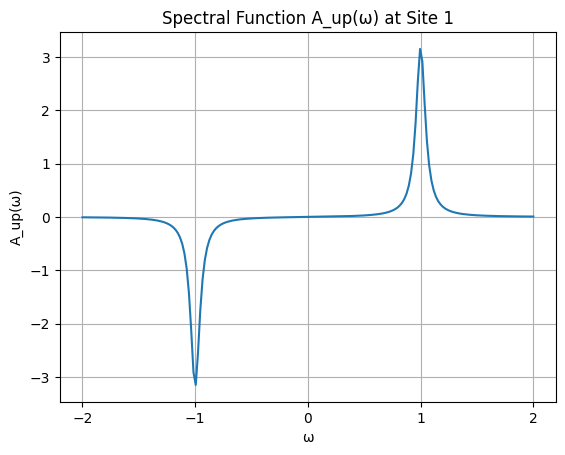

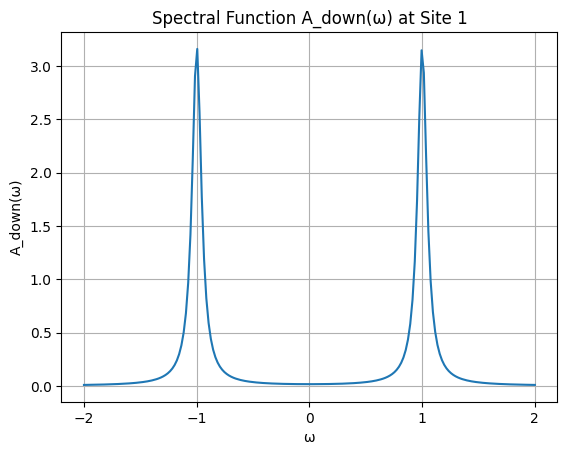

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Parameters
epsilon = 0.0  # orbital energy
t = 1.0       # hopping parameter
U = 0.001        # on-site interaction strength
eta = 0.05     # broadening for imaginary part

# Build Fock basis (2 sites x 2 spins => 4 orbitals => 16 states)
basis_size = 16
# Orbital indexing: 0=site1_up, 1=site1_down, 2=site2_up, 3=site2_down

def create_op(p):
    """Return the creation operator matrix for orbital p in the 16-dim Fock basis."""
    mat = np.zeros((basis_size, basis_size), dtype=complex)
    for s in range(basis_size):
        if not (s & (1 << p)):  # if orbital p is empty in state s
            # Determine sign from fermion parity
            sign = (-1)**bin(s & ((1 << p) - 1)).count("1")
            s_new = s | (1 << p)
            mat[s_new, s] = sign
    return mat

# Annihilation operators are adjoints of creation
c_dag = [create_op(p) for p in range(4)]
c = [op.conj().T for op in c_dag]

# Number operators
n_op = [c_dag[p] @ c[p] for p in range(4)]

# Construct the full Hamiltonian in the 16-dim Fock space
H = np.zeros((basis_size, basis_size), dtype=complex)

# Hopping term: -t sum_{σ} (c1σ† c2σ + h.c)
H += -t * (c_dag[0] @ c[2] + c_dag[2] @ c[0] + c_dag[1] @ c[3] + c_dag[3] @ c[1])

# On-site interaction: U * (n_{1↑} n_{1↓} + n_{2↑} n_{2↓})
H += U * (n_op[0] @ n_op[1] + n_op[2] @ n_op[3])

# Orbital energies: epsilon * sum_i n_iσ
H += epsilon * sum(n_op)

# Diagonalize Hamiltonian
E, V = np.linalg.eigh(H)

# Number operator for total electrons
N_tot = sum(n_op)

# Identify eigenstates by total particle number
def find_states_by_N(N):
    idxs = []
    for idx in range(basis_size):
        v = V[:, idx]
        n_val = np.real(v.conj().T @ (N_tot @ v))
        if abs(n_val - N) < 1e-6:
            idxs.append(idx)
    return idxs

idx_0 = find_states_by_N(0)[0]  # Vacuum
idx_1 = sorted(find_states_by_N(1), key=lambda i: E[i])[0]  # Ground state at N=1
idx_2 = find_states_by_N(2)  # All two-electron states

# Ground-state vectors and energies
psi0 = V[:, idx_0]
E0 = E[idx_0]
psi1 = V[:, idx_1]
E1 = E[idx_1]
psi2_list = [V[:, idx] for idx in idx_2]
E2_list = [E[idx] for idx in idx_2]

# Frequency grid
omega = np.linspace(-2, 2, 200)

# Function to compute Green's function for spin sector at site 1
def compute_G(p_index):
    G = np.zeros_like(omega, dtype=complex)
    # Removal (hole) contribution: N=1 -> N=0
    amp_rem = np.vdot(psi0, c[p_index] @ psi1)
    G += (abs(amp_rem)**2) / (omega - (E1 - E0) - 1j * eta)

    # Addition (particle) contributions: N=1 -> N=2
    for psi2, E2 in zip(psi2_list, E2_list):
        amp_add = np.vdot(psi2, c_dag[p_index] @ psi1)
        G += (abs(amp_add)**2) / (omega - (E2 - E1) + 1j * eta)

    return G

# Compute Green's functions for spin-up and spin-down at site 1
G_up = compute_G(p_index=0)
G_down = compute_G(p_index=1)

# Spectral functions A(ω) = -1/π Im G(ω)
A_up = -1/np.pi * np.imag(G_up)
A_down = -1/np.pi * np.imag(G_down)

# Plotting
plt.figure()
plt.plot(omega, A_up)
plt.title("Spectral Function A_up(ω) at Site 1")
plt.xlabel("ω")
plt.ylabel("A_up(ω)")
plt.grid(True)

ax = plt.gca()
# 1) Set major ticks every 1 unit
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# 2) (Optional) If you want minor ticks at, say, 0.5, do:
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Turn on the grid for major ticks
ax.grid(which='major', linestyle='-', linewidth=0.8)


plt.figure()
plt.plot(omega, A_down)
plt.title("Spectral Function A_down(ω) at Site 1")
plt.xlabel("ω")
plt.ylabel("A_down(ω)")
plt.grid(True)

ax = plt.gca()
# 1) Set major ticks every 1 unit
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# 2) (Optional) If you want minor ticks at, say, 0.5, do:
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Turn on the grid for major ticks
ax.grid(which='major', linestyle='-', linewidth=0.8)


plt.show()


### Interacting limit (U>>>t)

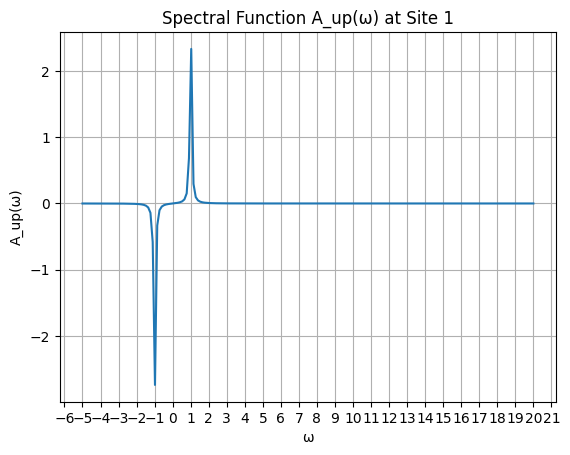

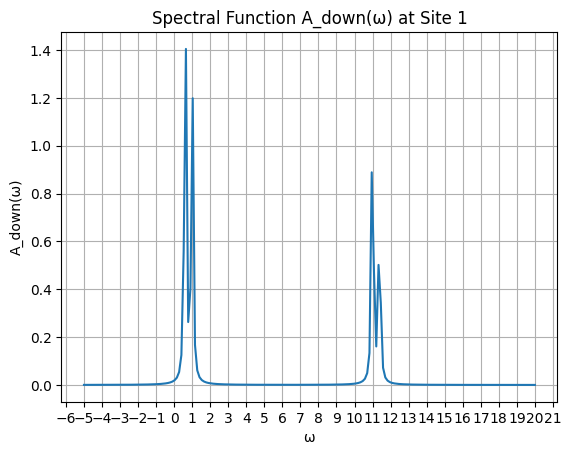

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Parameters
epsilon = 0.0  # orbital energy
t = 1.0       # hopping parameter
U = 10.0        # on-site interaction strength
eta = 0.05     # broadening for imaginary part

# Build Fock basis (2 sites x 2 spins => 4 orbitals => 16 states)
basis_size = 16
# Orbital indexing: 0=site1_up, 1=site1_down, 2=site2_up, 3=site2_down

def create_op(p):
    """Return the creation operator matrix for orbital p in the 16-dim Fock basis."""
    mat = np.zeros((basis_size, basis_size), dtype=complex)
    for s in range(basis_size):
        if not (s & (1 << p)):  # if orbital p is empty in state s
            # Determine sign from fermion parity
            sign = (-1)**bin(s & ((1 << p) - 1)).count("1")
            s_new = s | (1 << p)
            mat[s_new, s] = sign
    return mat

# Annihilation operators are adjoints of creation
c_dag = [create_op(p) for p in range(4)]
c = [op.conj().T for op in c_dag]

# Number operators
n_op = [c_dag[p] @ c[p] for p in range(4)]

# Construct the full Hamiltonian in the 16-dim Fock space
H = np.zeros((basis_size, basis_size), dtype=complex)

# Hopping term: -t sum_{σ} (c1σ† c2σ + h.c)
H += -t * (c_dag[0] @ c[2] + c_dag[2] @ c[0] + c_dag[1] @ c[3] + c_dag[3] @ c[1])

# On-site interaction: U * (n_{1↑} n_{1↓} + n_{2↑} n_{2↓})
H += U * (n_op[0] @ n_op[1] + n_op[2] @ n_op[3])

# Orbital energies: epsilon * sum_i n_iσ
H += epsilon * sum(n_op)

# Diagonalize Hamiltonian
E, V = np.linalg.eigh(H)

# Number operator for total electrons
N_tot = sum(n_op)

# Identify eigenstates by total particle number
def find_states_by_N(N):
    idxs = []
    for idx in range(basis_size):
        v = V[:, idx]
        n_val = np.real(v.conj().T @ (N_tot @ v))
        if abs(n_val - N) < 1e-6:
            idxs.append(idx)
    return idxs

idx_0 = find_states_by_N(0)[0]  # Vacuum
idx_1 = sorted(find_states_by_N(1), key=lambda i: E[i])[0]  # Ground state at N=1
idx_2 = find_states_by_N(2)  # All two-electron states

# Ground-state vectors and energies
psi0 = V[:, idx_0]
E0 = E[idx_0]
psi1 = V[:, idx_1]
E1 = E[idx_1]
psi2_list = [V[:, idx] for idx in idx_2]
E2_list = [E[idx] for idx in idx_2]

# Frequency grid
omega = np.linspace(-5, 20, 200)

# Function to compute Green's function for spin sector at site 1
def compute_G(p_index):
    G = np.zeros_like(omega, dtype=complex)
    # Removal (hole) contribution: N=1 -> N=0
    amp_rem = np.vdot(psi0, c[p_index] @ psi1)
    G += (abs(amp_rem)**2) / (omega - (E1 - E0) - 1j * eta)

    # Addition (particle) contributions: N=1 -> N=2
    for psi2, E2 in zip(psi2_list, E2_list):
        amp_add = np.vdot(psi2, c_dag[p_index] @ psi1)
        G += (abs(amp_add)**2) / (omega - (E2 - E1) + 1j * eta)

    return G

# Compute Green's functions for spin-up and spin-down at site 1
G_up = compute_G(p_index=0)
G_down = compute_G(p_index=1)

# Spectral functions A(ω) = -1/π Im G(ω)
A_up = -1/np.pi * np.imag(G_up)
A_down = -1/np.pi * np.imag(G_down)

# Plotting
plt.figure()
plt.plot(omega, A_up)
plt.title("Spectral Function A_up(ω) at Site 1")
plt.xlabel("ω")
plt.ylabel("A_up(ω)")
plt.grid(True)

ax = plt.gca()
# 1) Set major ticks every 1 unit
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# 2) (Optional) If you want minor ticks at, say, 0.5, do:
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Turn on the grid for major ticks
ax.grid(which='major', linestyle='-', linewidth=0.8)


plt.figure()
plt.plot(omega, A_down)
plt.title("Spectral Function A_down(ω) at Site 1")
plt.xlabel("ω")
plt.ylabel("A_down(ω)")
plt.grid(True)

ax = plt.gca()
# 1) Set major ticks every 1 unit
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# 2) (Optional) If you want minor ticks at, say, 0.5, do:
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Turn on the grid for major ticks
ax.grid(which='major', linestyle='-', linewidth=0.8)


plt.show()


As you can note, in the limit $U>>t$ we see that here are pairs of states in the exact spectrum at energies  $E\approx0$ and $E\approx U$ split by an amount $\delta\approx t^2/U$. **Why?**

In the large‑\(U\) limit the two‑site Hubbard‑dimer singlet energies are

$$
E_{\pm}
= \frac{U}{2}
\;\pm\;
\frac{1}{2}\,\sqrt{\,U^2 + 16\,t^2\,}\,.
$$

For \(U\gg t\) expand:

$$
\sqrt{U^2 + 16\,t^2}
= U\,\sqrt{1 + \frac{16\,t^2}{U^2}}
\approx U \Bigl(1 + \frac{8\,t^2}{U^2}\Bigr)
= U + \frac{8\,t^2}{U}\,.
$$

Hence

$$
E_{+} \approx U + \frac{4\,t^2}{U}, 
\qquad
E_{-} \approx -\,\frac{4\,t^2}{U}\,.
$$

The singlet–triplet splitting in both the low‑energy (\(E\approx0\)) and high‑energy (\(E\approx U\)) manifolds is

$$
\Delta E \;\approx\;\frac{4\,t^2}{U}\,,
$$

which is the familiar second‑order (\(t^2/U\)) superexchange scale.


### GW solution (from  Romaniello–Guyot–Reining J. Chem. Phys. )

The spin‑up self‑energy is given by

$$
\Sigma^{\uparrow}_{ij}(\omega)
= \frac{U^2\,t}{4\,h}\,
\Biggl[
\frac{1}{\omega - (\epsilon + t + h) + i\eta}
\;+\;
(-1)^{\,i-j}\,
\frac{1}{\omega - (\epsilon - t - h) - i\eta}
\Biggr]
$$

with 
$$
h = \sqrt{(4\,t)^2 + U^2}.
$$

And the spin‑down self‑energy reads

$$
\Sigma^{\downarrow}_{ij}(\omega)
= \frac{U}{2}\,\delta_{ij}
\;+\;
\frac{U^2\,t}{4\,h}
\Biggl[
\frac{1}{\omega - (\epsilon + t + h) + i\eta}
\;+\;
(-1)^{\,i-j}\,
\frac{1}{\omega - (\epsilon - t + h) + i\eta}
\Biggr].
$$



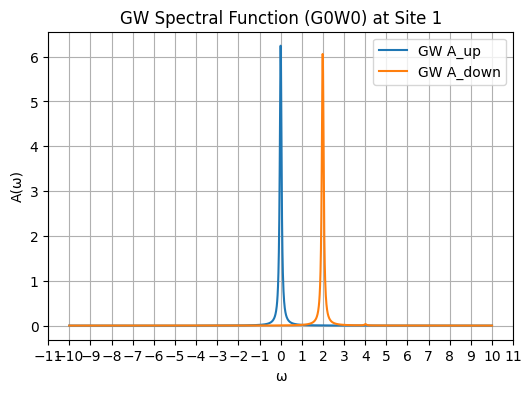

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Hubbard dimer
epsilon = 0.0  # on-site orbital energy
t = 0.01        # hopping parameter
U = 4        # on-site interaction
eta = 0.05     # small imaginary broadening

# Helper: complex inverse of a 2x2 matrix
def inv2(m):
    det = m[0,0]*m[1,1] - m[0,1]*m[1,0]
    return np.array([[ m[1,1], -m[0,1]], [-m[1,0], m[0,0]]], dtype=complex) / det

# Non-interacting (U=0) single-particle Green's function in the site basis for one spin
def G0_matrix(omega):
    # molecular orbital eigenvalues: ε0 ± t
    ep1 = epsilon - t
    ep2 = epsilon + t
    G_ep1 = 1.0 / (omega - ep1 + 1j*eta)
    G_ep2 = 1.0 / (omega - ep2 + 1j*eta)
    # site-basis transform: bonding/antibonding coefficients ±1/√2
    G00 = 0.5*(G_ep1 + G_ep2)
    G01 = 0.5*(-G_ep1 + G_ep2)
    return np.array([[G00, G01], [G01, G00]], dtype=complex)

# Analytic GW self-energy from the paper (non-self-consistent G0W0)
h = np.sqrt((4*t)**2 + U**2)

def Sigma_up_matrix(omega):
    # no Hartree for up-spin in one-electron ground state
    pref = (U**2 * t) / (4*h)
    pole1 = omega - (epsilon + t + h) + 1j*eta
    pole2 = omega - (epsilon - t - h) - 1j*eta
    term1 = 1/pole1
    term2 = 1/pole2
    s11 = pref*(term1 + term2)
    s12 = pref*(term1 - term2)  # (-1)^(i-j) gives minus sign for off-diagonal
    return np.array([[s11, s12], [s12, s11]], dtype=complex)

def Sigma_down_matrix(omega):
    # Hartree U/2 on each site plus dynamic part
    vH = U/2
    pref = (U**2 * t) / (4*h)
    pole1 = omega - (epsilon + t + h) + 1j*eta
    pole2 = omega - (epsilon - t + h) + 1j*eta
    term1 = 1/pole1
    term2 = 1/pole2
    s11 = vH + pref*(term1 + term2)
    s12 = pref*(term1 - term2)
    return np.array([[s11, s12], [s12, s11]], dtype=complex)

# Frequency grid
omega = np.linspace(-10, 10, 2000)

# Allocate spectral arrays
A_up = np.zeros_like(omega)
A_down = np.zeros_like(omega)

# Compute G_GW(ω) and spectral function at site 1 (index 0)
for i, w in enumerate(omega):
    G0 = G0_matrix(w)
    G0_inv = inv2(G0)
    # Spin-up
    Sigma_up = Sigma_up_matrix(w)
    G_up = inv2(G0_inv - Sigma_up)
    A_up[i] = -1/np.pi * np.imag(G_up[0,0])
    # Spin-down
    Sigma_down = Sigma_down_matrix(w)
    G_down = inv2(G0_inv - Sigma_down)
    A_down[i] = -1/np.pi * np.imag(G_down[0,0])

# Plotting
plt.figure(figsize=(6,4))
plt.plot(omega, A_up, label='GW A_up')
plt.plot(omega, A_down, label='GW A_down')
plt.title('GW Spectral Function (G0W0) at Site 1')
plt.xlabel('ω')
plt.ylabel('A(ω)')
plt.legend()
plt.grid(True)

ax = plt.gca()
# 1) Set major ticks every 1 unit
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# 2) (Optional) If you want minor ticks at, say, 0.5, do:
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Turn on the grid for major ticks
ax.grid(which='major', linestyle='-', linewidth=0.8)

plt.show()


### Self Consistent GW

Current iteration: 1 (ΔG = 1.08e+01)
Current iteration: 2 (ΔG = 1.31e+00)
Current iteration: 3 (ΔG = 1.30e+00)
Current iteration: 4 (ΔG = 1.32e+00)
Current iteration: 5 (ΔG = 1.26e+00)
Current iteration: 6 (ΔG = 1.27e+00)
Current iteration: 7 (ΔG = 1.27e+00)
Current iteration: 8 (ΔG = 1.27e+00)
Current iteration: 9 (ΔG = 1.27e+00)
Current iteration: 10 (ΔG = 1.27e+00)
Current iteration: 11 (ΔG = 1.27e+00)
Current iteration: 12 (ΔG = 1.27e+00)
Current iteration: 13 (ΔG = 1.27e+00)
Current iteration: 14 (ΔG = 1.27e+00)
Current iteration: 15 (ΔG = 1.27e+00)
Current iteration: 16 (ΔG = 1.27e+00)
Current iteration: 17 (ΔG = 1.27e+00)
Current iteration: 18 (ΔG = 1.27e+00)
Current iteration: 19 (ΔG = 1.27e+00)
Current iteration: 20 (ΔG = 1.27e+00)


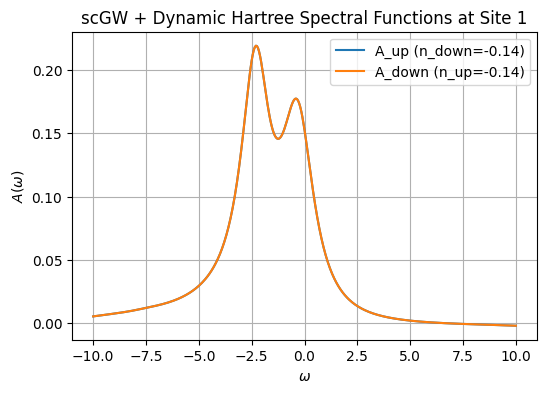

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.0   # on-site orbital energy
t = 1.0         # hopping parameter
U = 4.0         # on-site interaction
eta = 0.05      # small imaginary broadening

# Frequency grid
n_omega = 401
omega = np.linspace(-10, 10, n_omega)
domega = omega[1] - omega[0]

# Non-interacting Green's function (site basis)
def G0_matrix(ω):
    ep1, ep2 = epsilon - t, epsilon + t
    Gp = 1.0 / (ω - ep1 + 1j*eta)
    Gm = 1.0 / (ω - ep2 + 1j*eta)
    G00 = 0.5 * (Gp + Gm)
    G01 = 0.5 * (-Gp + Gm)
    return np.array([[G00, G01],
                     [G01, G00]], dtype=complex)

# Precompute G0 and its inverse
G0 = np.array([G0_matrix(w) for w in omega])
G0_inv = np.array([np.linalg.inv(G0_matrix(w)) for w in omega])

# Initialize G_up and G_down to G0
G_up = G0.copy()
G_down = G0.copy()

# Identity matrix
I2 = np.eye(2)

# Self-consistent GW+Hartree loop
max_iter = 20
tol = 1e-6

for it in range(max_iter):
    # Compute spin densities from previous spectral functions
    # This is done to add a small Hartree screening, but it does
    # Not work to break the spin symmetry.
    A_up = -1/np.pi * np.imag(G_up[:, 0, 0])
    A_down = -1/np.pi * np.imag(G_down[:, 0, 0])
    mu = 0.0
    f = (omega < mu).astype(float)
    n_up = np.trapz(A_up * f, omega)
    n_down = np.trapz(A_down * f, omega)
    
    # Polarizability P = -i/(2π) ∑ Gσ(ω+ω') Gσ(ω') dω'
    P = np.zeros_like(G_up, dtype=complex)
    for i, w in enumerate(omega):
        tmp = np.zeros((2,2), dtype=complex)
        for j, wp in enumerate(omega):
            k_plus = np.argmin(np.abs(omega - (w + wp)))
            tmp += G_up[k_plus] @ G_up[j] * domega
            tmp += G_down[k_plus] @ G_down[j] * domega
        P[i] = -1j / (2*np.pi) * tmp

    # Screened interaction W = (I - U P)^{-1} U
    W = np.zeros_like(P, dtype=complex)
    for i in range(n_omega):
        W[i] = np.linalg.inv(I2 - U * P[i]) @ (U * I2)

    # Self-energies Σσ = i/(2π) ∫ Gσ(ω - ω') W(ω') dω' + Hartree
    # Here we are ignoring the Hartree term
    Sigma_up = np.zeros_like(P, dtype=complex)
    Sigma_down = np.zeros_like(P, dtype=complex)
    for i, w in enumerate(omega):
        tmp_up = np.zeros((2,2), dtype=complex)
        tmp_down = np.zeros((2,2), dtype=complex)
        for j, wp in enumerate(omega):
            k_minus = np.argmin(np.abs(omega - (w - wp)))
            tmp_up   += G_up[k_minus] @ W[j] * domega
            tmp_down += G_down[k_minus] @ W[j] * domega
        Sigma_up[i]   = 1j / (2*np.pi) * tmp_up
        Sigma_down[i] = 1j / (2*np.pi) * tmp_down
        # Add static Hartree shift: each spin feels U * density of opposite spin
        # commented because it does not work (does not assymetrice the up-down solution) 
        #Sigma_up[i]   += U * n_down * I2
        #Sigma_down[i] += U * n_up   * I2

    # Dyson update Gσ = (G0^{-1} - Σσ)^{-1}
    G_up_new   = np.array([np.linalg.inv(G0_inv[i] - Sigma_up[i])   for i in range(n_omega)])
    G_down_new = np.array([np.linalg.inv(G0_inv[i] - Sigma_down[i]) for i in range(n_omega)])

    # Check convergence
    diff = max(np.max(np.abs(G_up_new - G_up)), np.max(np.abs(G_down_new - G_down)))
    G_up, G_down = G_up_new, G_down_new
    # Print checks
    print(f"Current iteration: {it+1} (ΔG = {diff:.2e})")
    if diff < tol:
        print(f"Converged in {it+1} iterations (ΔG = {diff:.2e})")
        break

# Compute final spectral functions
A_up = -1/np.pi * np.imag(G_up[:, 0, 0])
A_down = -1/np.pi * np.imag(G_down[:, 0, 0])

# Plot results
plt.figure(figsize=(6,4))
plt.plot(omega, A_up, label=f'A_up (n_down={n_down:.2f})')
plt.plot(omega, A_down, label=f'A_down (n_up={n_up:.2f})')
plt.xlabel(r'$\omega$'); plt.ylabel(r'$A(\omega)$')
plt.title('scGW + Dynamic Hartree Spectral Functions at Site 1')
plt.legend(); plt.grid(True); plt.show()
